In [5]:
#for each radar volumes
#extract 5 min gauge accumulations
#extract rainrate at each gauge location
#plot!

"""

"""

'\n\n'

In [127]:
import os
from glob import glob
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import cftime

import pyart

import verify_util as util

In [98]:
def radar_rainrate_ts(vol_ffn, aws_list, aws_data):
    
    accu_min = 6 #minutes
    tilt = 0 #index
    
    #read radar 
    radar = pyart.io.read(vol_ffn)
    
    #extract field
    zr_data = radar.get_field(tilt, 'zr_rainrate').filled()
    ar_data = radar.get_field(tilt, 'ah_rainrate').filled()
    kdpr_data = radar.get_field(tilt, 'kdp_rainrate').filled()
    hybrid_data = radar.get_field(tilt, 'hybrid_rainrate').filled()
    
    #extract lat lon grid for volume
    gate_lat = radar.gate_latitude['data']
    gate_lon = radar.gate_longitude['data']
    #extract tilt index
    tilt_start_idx = radar.sweep_start_ray_index['data']
    tilt_end_idx   = radar.sweep_end_ray_index['data']
    #extract lat lon grid for tilt
    tilt_lat       = gate_lat[tilt_start_idx[tilt]:tilt_end_idx[tilt]+1, :]
    tilt_lon       = gate_lon[tilt_start_idx[tilt]:tilt_end_idx[tilt]+1, :]
    #sweep time
    sweep_time_array = radar.time['data'][tilt_start_idx[tilt]:tilt_end_idx[tilt]+1]    
    sweep_dtime_array = cftime.num2pydate(sweep_time_array[:], radar.time['units'])
    sweep_dtime = sweep_dtime_array[int(len(sweep_dtime_array)/2)] #get mid-ray time.
    #remove seconds
    sweep_dtime = sweep_dtime - timedelta(seconds = sweep_dtime.second)
    
    #get gatefilter from specific attenuation
    radar_mask = np.ma.getmask(radar.fields['specific_attenuation']['data'][tilt_start_idx[tilt]:tilt_end_idx[tilt]+1, :])
    
    #apply mask
    zr_data[radar_mask] = 0.
    ar_data[radar_mask] = 0.
    kdpr_data[radar_mask] = 0.
    hybrid_data[radar_mask] = 0.
    
    output_data = []
    
    for i,aws_site in enumerate(aws_list):
        
        #get gauge data
        gauge_obs = aws_data[i]['rain']
        gauge_dt = aws_data[i]['dt']
        
        #cost function for nearest radar grid point
        cost = np.sqrt((tilt_lon - aws_site[3])**2 \
                + (tilt_lat - aws_site[2])**2) #A cost function for searching
        index = np.where(cost == cost.min())
        
        #extract values from each field
        zr_value = zr_data[index][0]
        ar_value = ar_data[index][0]
        kdpr_value = kdpr_data[index][0]
        hybrid_value = hybrid_data[index][0]
        
        #accumulate rain
        acc_end_dt = sweep_dtime + timedelta(minutes=accu_min)
        acc_sum = 0
        for j, dt in enumerate(gauge_dt):
            #accumulate rain
            if dt >= sweep_dtime and dt < acc_end_dt:
                acc_sum += gauge_obs[j]
        
        #calc rainrate in mm/hr
        gauge_rate = acc_sum*(60/(accu_min))
    
        #append outputs
        output_data.append([gauge_rate, zr_value, ar_value, kdpr_value, hybrid_value])
    
    return output_data, sweep_dtime
    
    

In [94]:
aws_path = '/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/aws'
cp2_path = '/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2'

aws_list = [['040913','BRISBANE',-27.4808, 153.0389],
            ['040842','BRISBANE AERO',-27.3917, 153.1292],
            ['040211','ARCHERFIELD AIRPORT',-27.5716, 153.0071],
            ['040958','REDCLIFFE',-27.2169, 153.0922],
            ['040004','AMBERLEY AMO',-27.6297, 152.7111],
            ['040983','BEAUDESERT DRUMLEY STREET',-27.9707, 152.9898]]

In [95]:
#load AWS data
aws_data = []
for aws_site in aws_list:
    aws_ffn_list = glob(aws_path + '/*' + aws_site[0] + '*.txt')
    aws_dict = util.read_rain_1min(aws_ffn_list)
    aws_data.append(aws_dict)

In [129]:
vol_ffn_list = sorted(glob(cp2_path + '/*.nc'))

output_list = []
dt_list = []
for vol_ffn in vol_ffn_list[50:80]:
    print(vol_ffn)
    sample, dt = radar_rainrate_ts(vol_ffn, aws_list, aws_data)
    output_list.append(sample)
    dt_list.append(dt)
    

/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_050500.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_051101.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_051702.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_052301.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_052903.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_053504.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_054102.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_054705.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20141127_055303.sur.cfradial.nc
/g/data/kl02/jss548/PST/polarimetric_rain/casestudy_20141127/cp2/cp2-s_20

Totals for BRISBANE Gauge 41.0 ZR 23.0 AH 10.0 KDP 20.0 HYBRID 17.0
040913
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 76.0, 192.0, 63.99999999999999, 52.0, 10.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0]
Totals for BRISBANE AERO Gauge 7.0 ZR 43.0 AH 12.0 KDP 18.0 HYBRID 18.0
040842
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.000000000000004, 24.0, 8.0, 8.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]
Totals for ARCHERFIELD AIRPORT Gauge 71.0 ZR 43.0 AH 34.0 KDP 23.0 HYBRID 26.0
040211
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 214.0, 196.0, 180.0, 77.99999999999999, 6.000000000000001, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0]
Totals for REDCLIFFE Gauge 15.0 ZR 52.0 AH 28.0 KDP 27.0 HYBRID 25.0
040958
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 28.000000000000004, 36.0, 10.0, 8.0, 4.0, 0

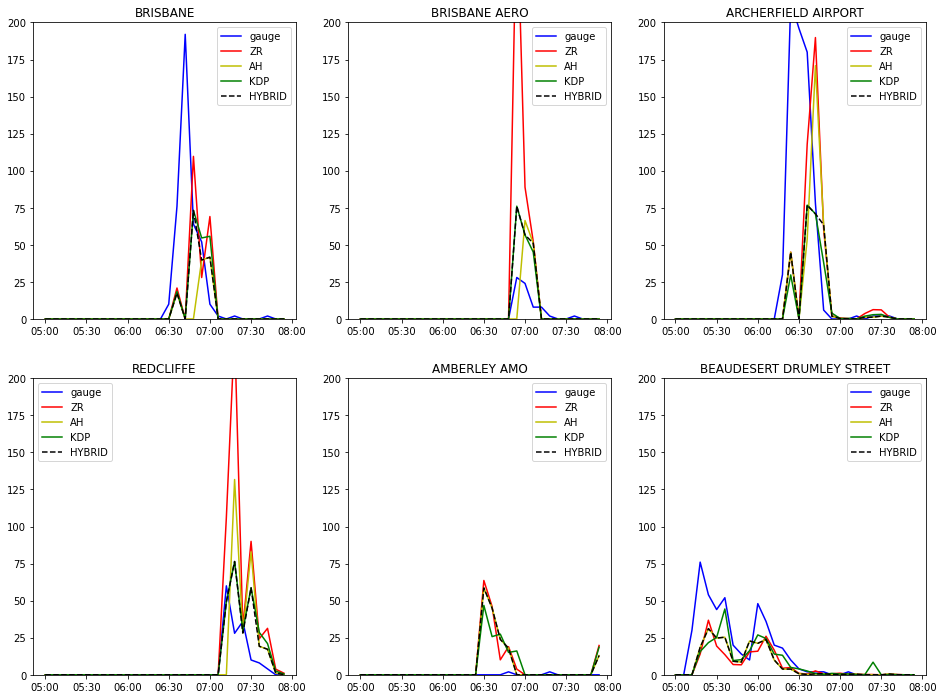

In [134]:
#plot Brisbane

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[16,12]) 

for i, aws_site in enumerate(aws_list):

    #rebuild timeseries
    plot_obs = []
    plot_zr = []
    plot_ar = []
    plot_kdpr = []
    plot_hybrid = []
    for item in output_list:
        plot_obs.append(item[i][0])
        plot_zr.append(item[i][1])
        plot_ar.append(item[i][2])
        plot_kdpr.append(item[i][3])
        plot_hybrid.append(item[i][4])

    
    if i>2:
        ax_j = i-3
        ax_i = 1
    else:
        ax_j = i
        ax_i = 0
    
    axs[ax_i, ax_j].plot(dt_list, plot_obs,'b-', label='gauge')
    axs[ax_i, ax_j].plot(dt_list, plot_zr,'r-', label='ZR')
    axs[ax_i, ax_j].plot(dt_list, plot_ar,'y-', label='AH')
    axs[ax_i, ax_j].plot(dt_list, plot_kdpr,'g-', label='KDP')
    axs[ax_i, ax_j].plot(dt_list, plot_hybrid,'k--', label='HYBRID')
    axs[ax_i, ax_j].set_title(aws_site[1])
    axs[ax_i, ax_j].legend()
    axs[ax_i, ax_j].set_ylim([0,200])
    axs[ax_i, ax_j].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    
    print('Totals for', aws_site[1], 'Gauge',round(np.sum(plot_obs)/10), 'ZR',round(np.sum(plot_zr)/10), 'AH',round(np.sum(plot_ar)/10),
         'KDP',round(np.sum(plot_kdpr)/10), 'HYBRID', round(np.sum(plot_hybrid)/10))
    print(aws_site[0])
    print(plot_obs)